In [29]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
%autoreload 2
import h5py
import matplotlib.pyplot as plt
from nolitsa import delay, lyapunov
import numpy as np
from scipy import signal
from sklearn.decomposition import PCA
from statsmodels.tsa import stattools
import sys
import time 
from tqdm.notebook import tqdm

sys.path.append('..')
from utils import *
from nld_utils import *

In [31]:
data_path = '../__data__/Mary-Anesthesia-20160809-01.mat'
f = h5py.File(data_path, 'r')
dt = get_sample_interval(f, 's')
lfp_areas = [to_string(item, f) for item in f['electrodeInfo']['area'][0]]

In [32]:
airPuff_binary, audio_binary = get_binary_stimuli(f)
stimuli = get_stimuli_start_and_end_flags(f)
get_phase_ranges(f)

{'experiment': array([[   0.   , 7085.395]]),
 'initial_phase': array([[   0.        , 1875.35996667]]),
 'loading_phase': array([[1875.35996667, 3675.35996667]]),
 'maintenance_phase': array([[3675.35996667, 5494.06313333]]),
 'unconscious_phase': array([[2315.67226667, 5618.68623333]]),
 'conscious_phase': array([[   0.        , 2315.67226667],
        [5618.68623333, 7085.395     ]]),
 'post_anesthesia_phase': array([[5494.06313333, 7085.395     ]])}

# LFP

In [34]:
# ==============
# INPUTS
# ==============

unit_index = 0
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 60
maxt = 1000

# ========
trajectory_start_steps = np.int0(trajectory_start_times/dt)
length = int(duration/dt)

results = []

for start_step in tqdm(trajectory_start_steps):
    signal_in = f['lfp'][unit_index, start_step:start_step + length]
    ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
    ret['signal'] = signal_in
    ret['airPuff'] = airPuff_binary[start_step:start_step + length]
    ret['audio'] = audio_binary[start_step:start_step + length]
    ret['start_step'] = start_step
    
    results.append(ret)

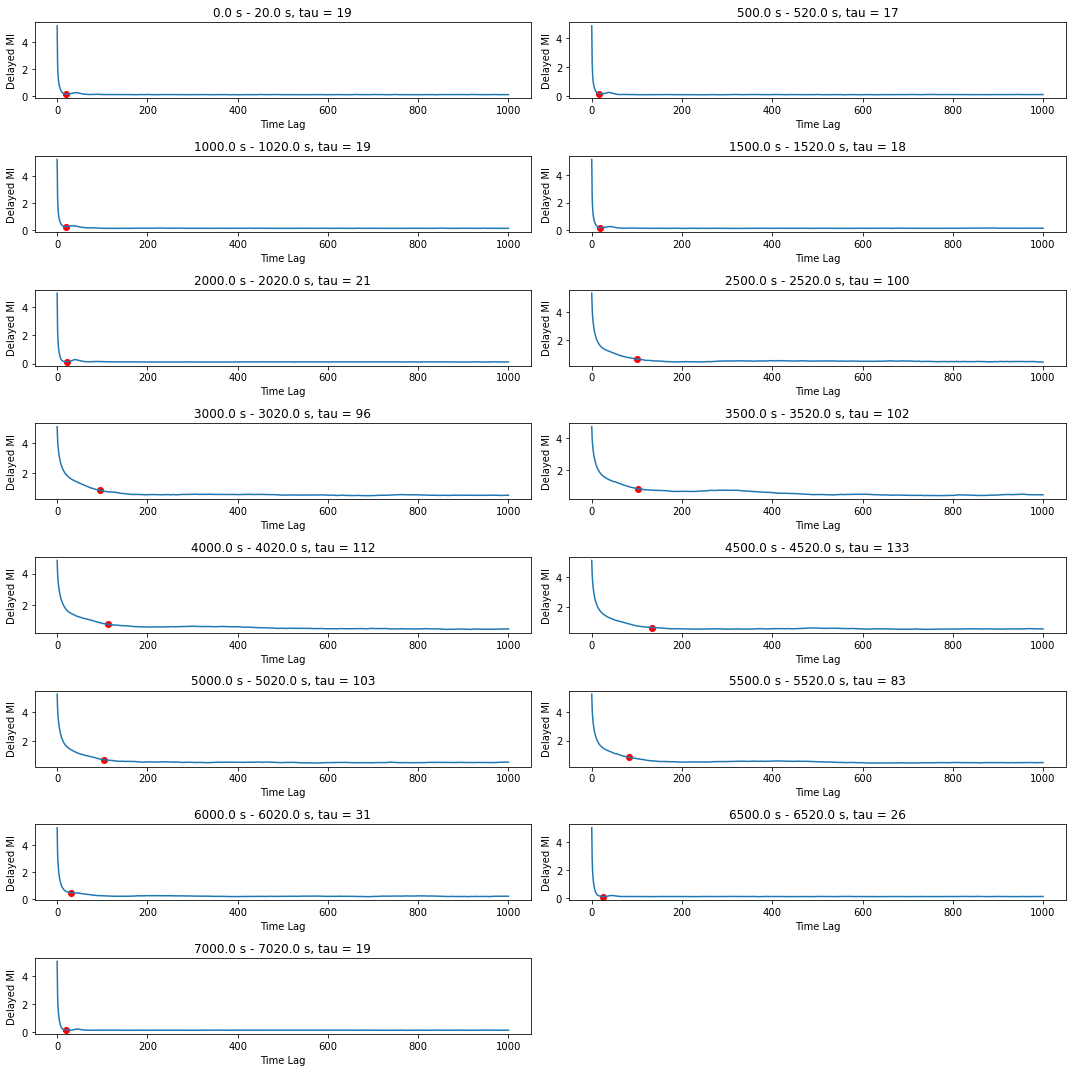

In [40]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['delayed_mi'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, tau = {ret['tau']}")
    plt.scatter(ret['tau'], ret['delayed_mi'][ret['tau']], c='red')
    plt.xlabel(r'Time Lag')
    plt.ylabel(r'Delayed MI')
plt.tight_layout()
plt.show()

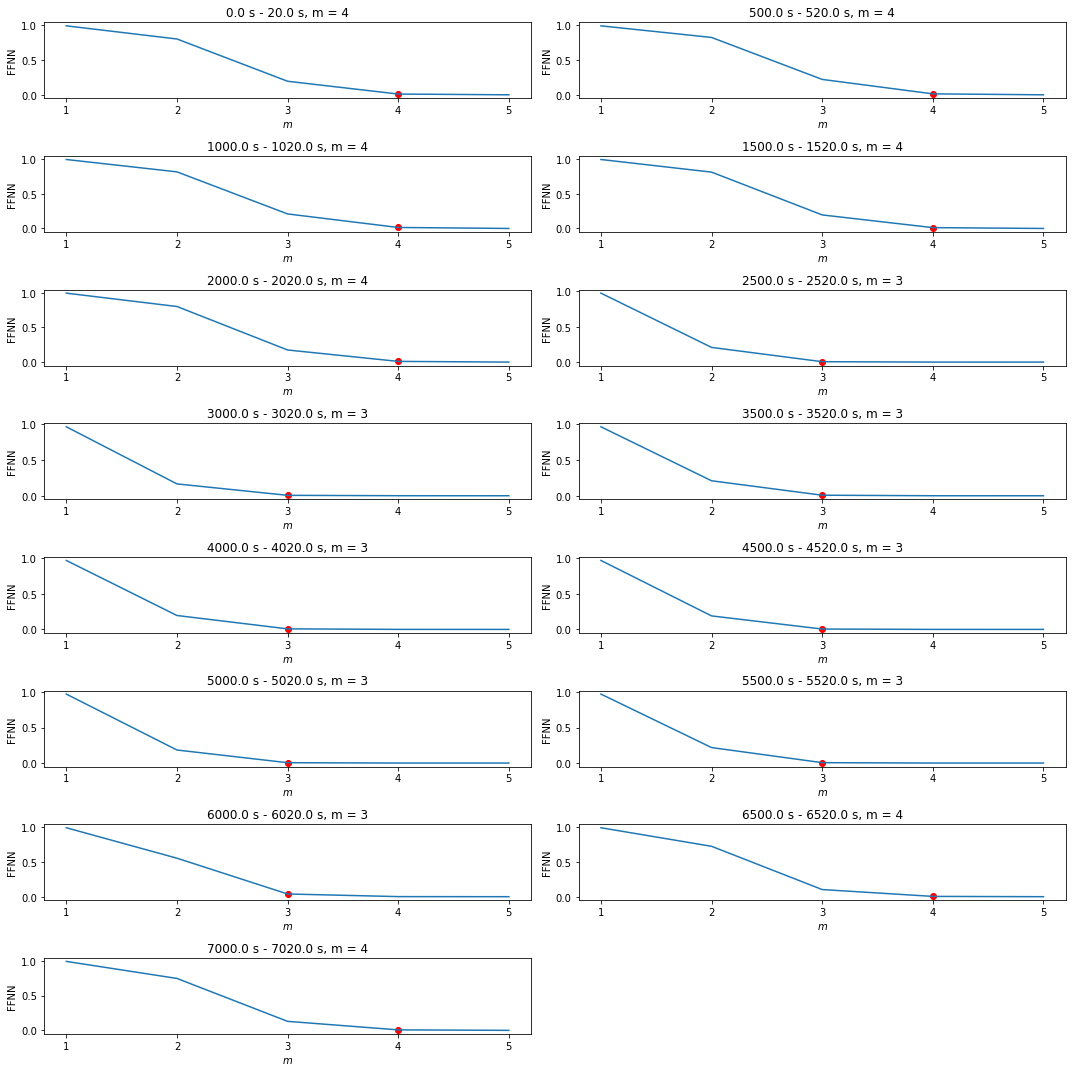

In [42]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s, m = {ret['m']}")
    plt.scatter(ret['m'], ret['fraction_fnn'][ret['m'] - 1], c='red')
    plt.xticks(ret['m_vals'], ret['m_vals'])
    plt.xlabel(r'$m$')
    plt.ylabel(r'FFNN')
plt.tight_layout()
plt.show()

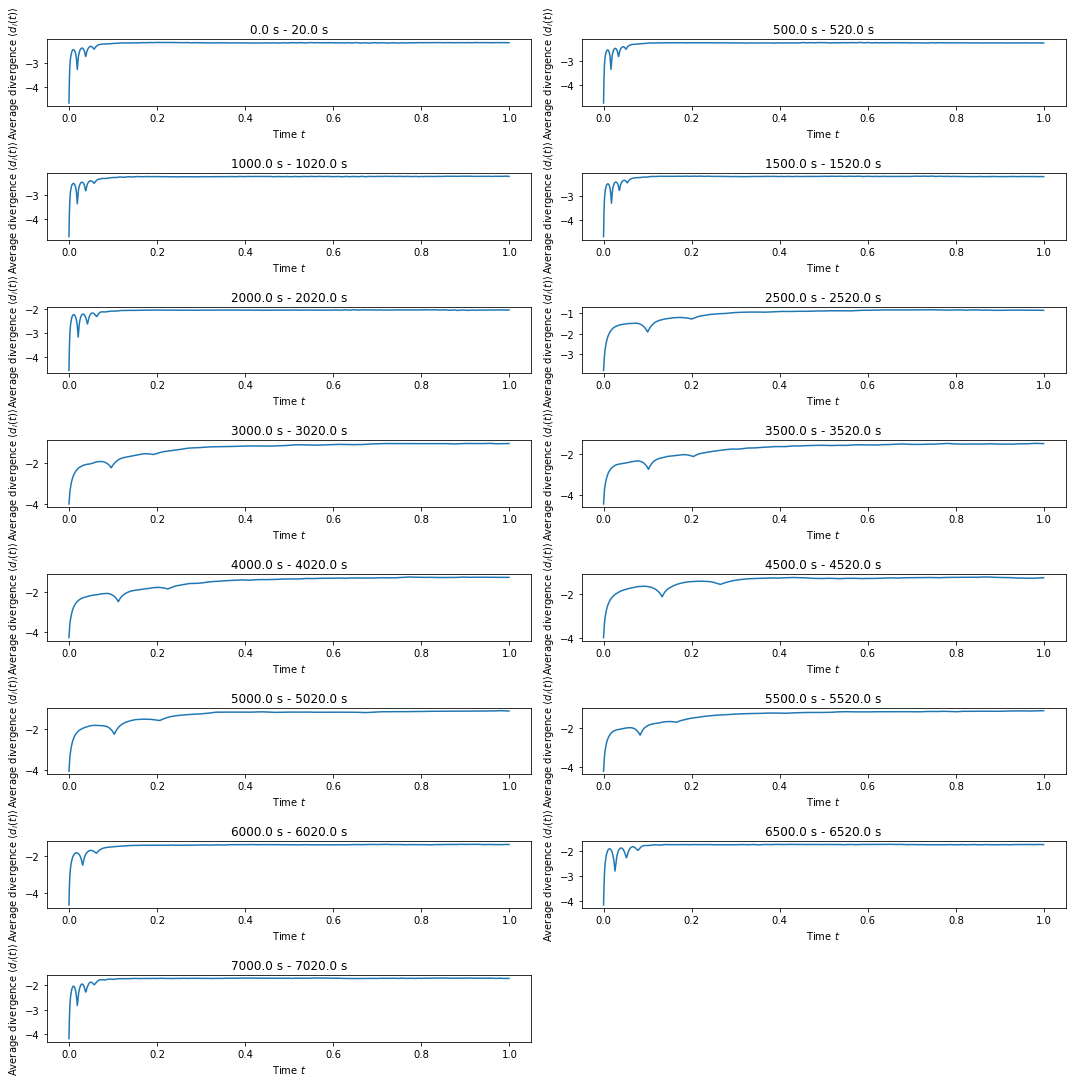

In [44]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['t']*dt, ret['d'])
    plt.title(f"{ret['start_step']*dt} s - {ret['start_step']*dt + duration} s")
    plt.xlabel(r'Time $t$')
    plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

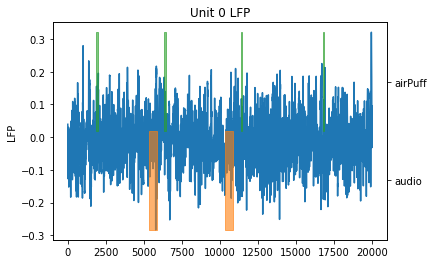

In [47]:
plt.plot(ret['signal'])
ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(np.arange(len(ret['signal'])), 0, 1, where=ret['airPuff'], color='C2', alpha=0.6)
ax2.fill_between(np.arange(len(ret['signal'])), -1, 0, where=ret['audio'], color='C1', alpha=0.6)
ax2.set_yticks([-0.5, 0.5])
ax2.set_yticklabels(['audio', 'airPuff'])
ax.set_ylabel('LFP')
plt.title(f'Unit {unit_index} LFP')
plt.show()

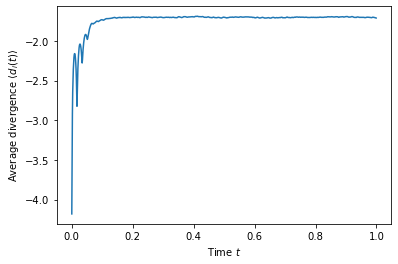

In [86]:
plt.plot(ret['t']*dt, ret['d'])
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.show()

# Firing Rates

In [265]:
# firing rates only
window = 250
stride = 25
test_duration = get_test_duration(f)

vlPFC_fr = None
for unit_index in tqdm(range(248)):
    if to_string(f[f['unitInfo']['area'][0, unit_index]]) == "vlPFC":
        fr, bins = spike_times_to_firing_rate(get_unit_spikes(unit_index, f)['spike_times'], window=window, stride=stride, test_duration=test_duration, progress_bar=False)
        if vlPFC_fr is None:
            vlPFC_fr = fr
        else:
            vlPFC_fr = np.vstack([vlPFC_fr, fr])

In [266]:
pca = PCA().fit(vlPFC_fr.T)

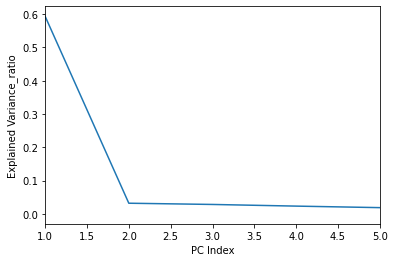

In [267]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)) + 1, pca.explained_variance_ratio_)
plt.xlim([1, 5])
plt.xlabel("PC Index")
plt.ylabel("Explained Variance_ratio")
plt.show()

In [268]:
fr_PCA = PCA().fit_transform(vlPFC_fr.T)

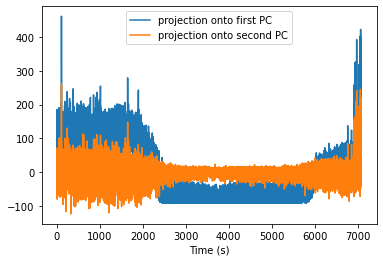

In [269]:
plt.plot(bins, fr_PCA[:, 0], label="projection onto first PC")
plt.plot(bins, fr_PCA[:, 1], label="projection onto second PC")
plt.legend()
plt.xlabel('Time (s)')
plt.show()

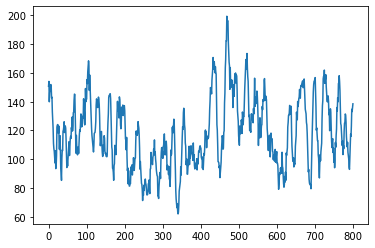

In [270]:
start_step = 500
plt.plot(fr_PCA[:, 0][np.argmax(bins > start_step):np.argmax(bins > start_step + duration)])
plt.show()

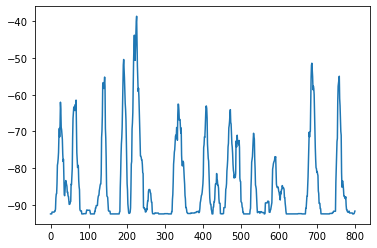

In [271]:
start_step = 4000
plt.plot(fr_PCA[:, 0][np.argmax(bins > start_step):np.argmax(bins > start_step + duration)])
plt.show()

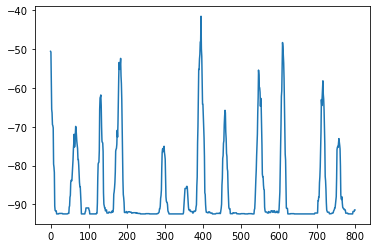

In [282]:
start_time
signal_in = fr_PCA[:, 0][np.argmax(bins > start_time):np.argmax(bins > start_time + duration)]
plt.plot(signal_in)

In [5]:
# # ==============
# INPUTS
# ==============

unit_index = 0
trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 60
maxt = 500

# # firing rates only
# window = 250
# stride = 50
# test_duration = get_test_duration(f)

# ========

length = int(duration*1000)
results_fr = []

for start_time in tqdm(trajectory_start_times):
#     fr, bins = spike_times_to_firing_rate(get_unit_spikes(0, f)['spike_times'], window=window, stride=stride, test_duration=test_duration, progress_bar=False)
    signal_in = fr_PCA[:, 0][np.argmax(bins > start_time):np.argmax(bins > start_time + duration)]
    start_step = int(start_time*1000)
    ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
    ret['signal'] = signal_in
    ret['airPuff'] = airPuff_binary[start_step:start_step + length]
    ret['audio'] = audio_binary[start_step:start_step + length]
    ret['start_time'] = start_time
    ret['start_bin'] = np.argmax(bins > start_step)
    ret['end_bin'] = np.argmax(bins > start_step + duration)
    
    results_fr.append(ret)

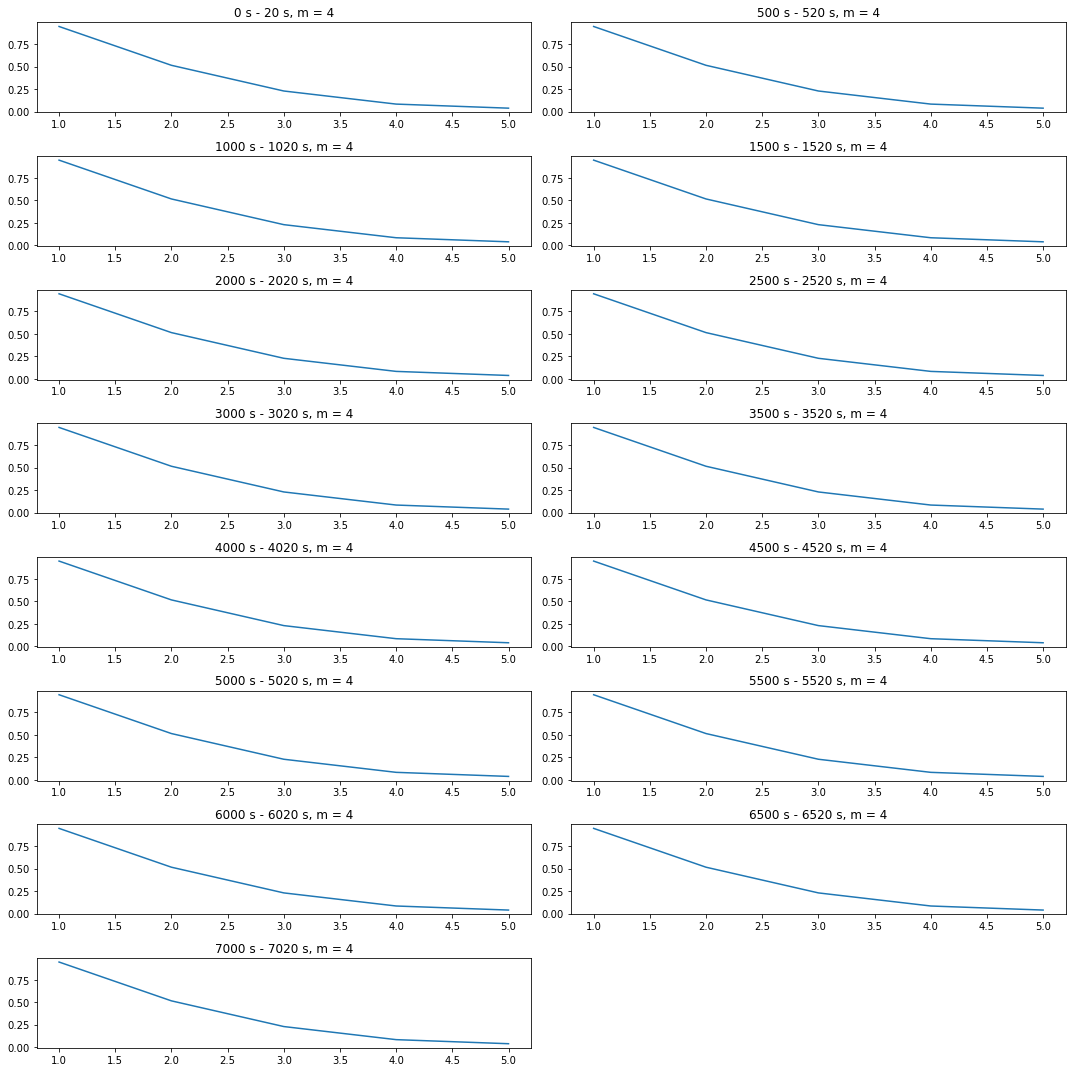

In [277]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_time']} s - {ret['start_time'] + duration} s, m = {ret['m']}")
#     plt.xlabel(r'Time $t$')
#     plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

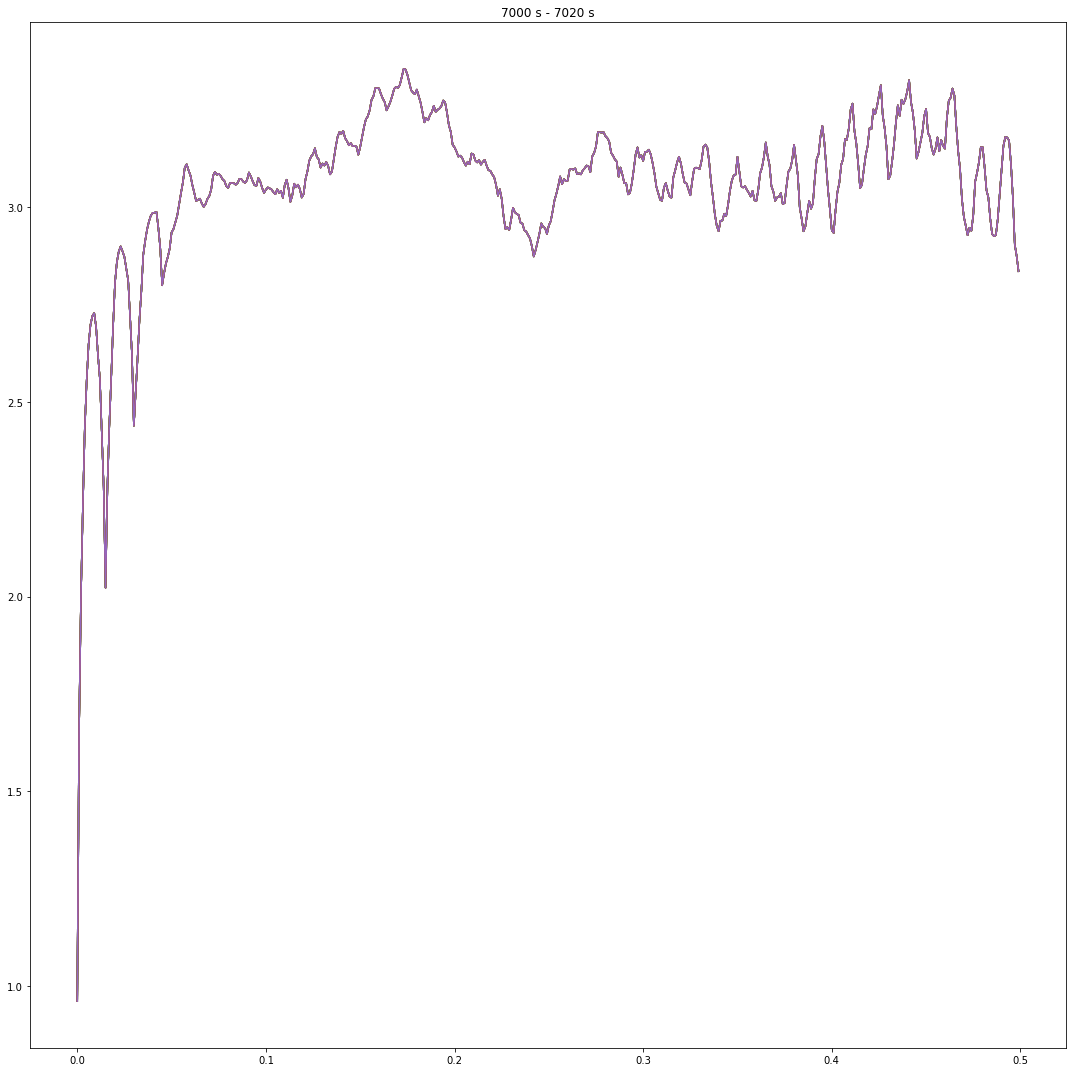

In [279]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['t']*dt, ret['d'])
    plt.title(f"{ret['start_time']} s - {ret['start_time'] + duration} s")
#     plt.xlabel(r'Time $t$')
#     plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

## PCA v2

In [7]:
# firing rates only
window = 250
stride = 25
test_duration = get_test_duration(f)

vlPFC_fr = None
for unit_index in tqdm(range(248)):
    if to_string(f[f['unitInfo']['area'][0, unit_index]]) == "vlPFC":
        fr, bins = spike_times_to_firing_rate(get_unit_spikes(unit_index, f)['spike_times'], window=window, stride=stride, test_duration=test_duration, progress_bar=False)
        if vlPFC_fr is None:
            vlPFC_fr = fr
        else:
            vlPFC_fr = np.vstack([vlPFC_fr, fr])

In [9]:
start_time = 4000
duration = 20

In [14]:
start_bin = np.argmax(bins > start_time)
end_bin = np.argmax(bins > start_time + duration)
pca = PCA().fit(vlPFC_fr.T[start_bin:end_bin])

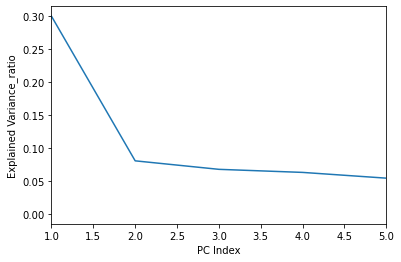

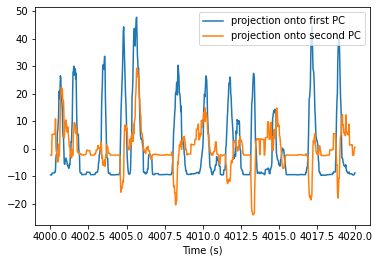

In [15]:
plt.plot(np.arange(len(pca.explained_variance_ratio_)) + 1, pca.explained_variance_ratio_)
plt.xlim([1, 5])
plt.xlabel("PC Index")
plt.ylabel("Explained Variance_ratio")
plt.show()

fr_PCA = PCA().fit_transform(vlPFC_fr.T[start_bin:end_bin])

plt.plot(bins[start_bin:end_bin], fr_PCA[:, 0], label="projection onto first PC")
plt.plot(bins[start_bin:end_bin], fr_PCA[:, 1], label="projection onto second PC")
plt.legend()
plt.xlabel('Time (s)')
plt.show()

In [25]:
# ==============
# INPUTS
# ==============

unit_index = 0
trajectory_start_times = np.arange(0, 6501, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 60
maxt = 500

# # firing rates only
# window = 250
# stride = 50
# test_duration = get_test_duration(f)

# ========

length = duration*1000

results_fr = []

for start_time in tqdm(trajectory_start_times):
    try:
#     fr, bins = spike_times_to_firing_rate(get_unit_spikes(0, f)['spike_times'], window=window, stride=stride, test_duration=test_duration, progress_bar=False)
        start_step = int(start_time*1000)
        start_bin = np.argmax(bins > start_time)
        end_bin = np.argmax(bins > start_time + duration)
        fr_PCA = PCA().fit_transform(vlPFC_fr.T[start_bin:end_bin])
        signal_in = fr_PCA[:, 0]
        ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
        ret['signal'] = signal_in
        ret['airPuff'] = airPuff_binary[start_step:start_step + length]
        ret['audio'] = audio_binary[start_step:start_step + length]
        ret['start_time'] = start_time
        ret['start_bin'] = start_bin
        ret['end_bin'] = end_bin

        results_fr.append(ret)
    except:
        start_time += 100
        start_step = int(start_time*1000)
        start_bin = np.argmax(bins > start_time)
        end_bin = np.argmax(bins > start_time + duration)
        fr_PCA = PCA().fit_transform(vlPFC_fr.T[start_bin:end_bin])
        signal_in = fr_PCA[:, 0]
        ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
        ret['signal'] = signal_in
        ret['airPuff'] = airPuff_binary[start_step:start_step + length]
        ret['audio'] = audio_binary[start_step:start_step + length]
        ret['start_time'] = start_time
        ret['start_bin'] = start_bin
        ret['end_bin'] = end_bin

        results_fr.append(ret)

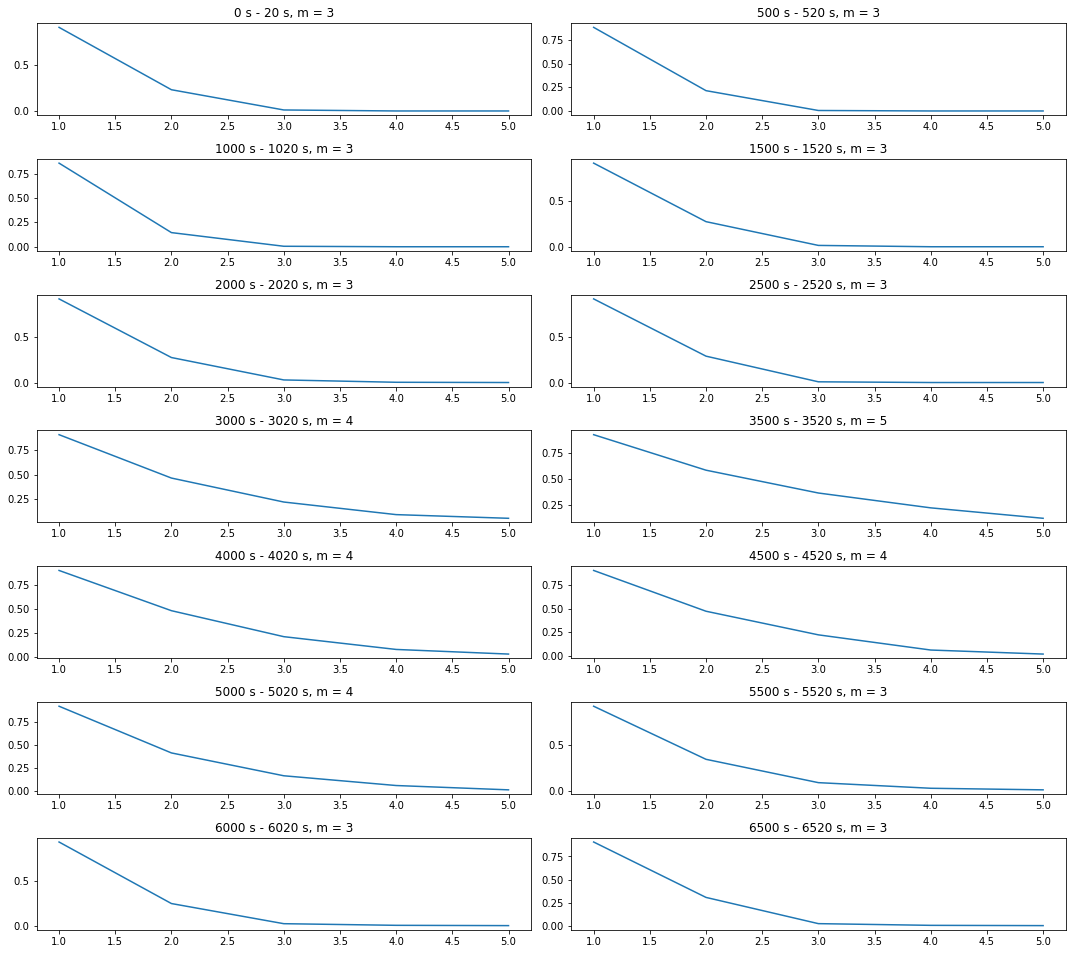

In [26]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot(ret['m_vals'], ret['fraction_fnn'])
    plt.title(f"{ret['start_time']} s - {ret['start_time'] + duration} s, m = {ret['m']}")
#     plt.xlabel(r'Time $t$')
#     plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

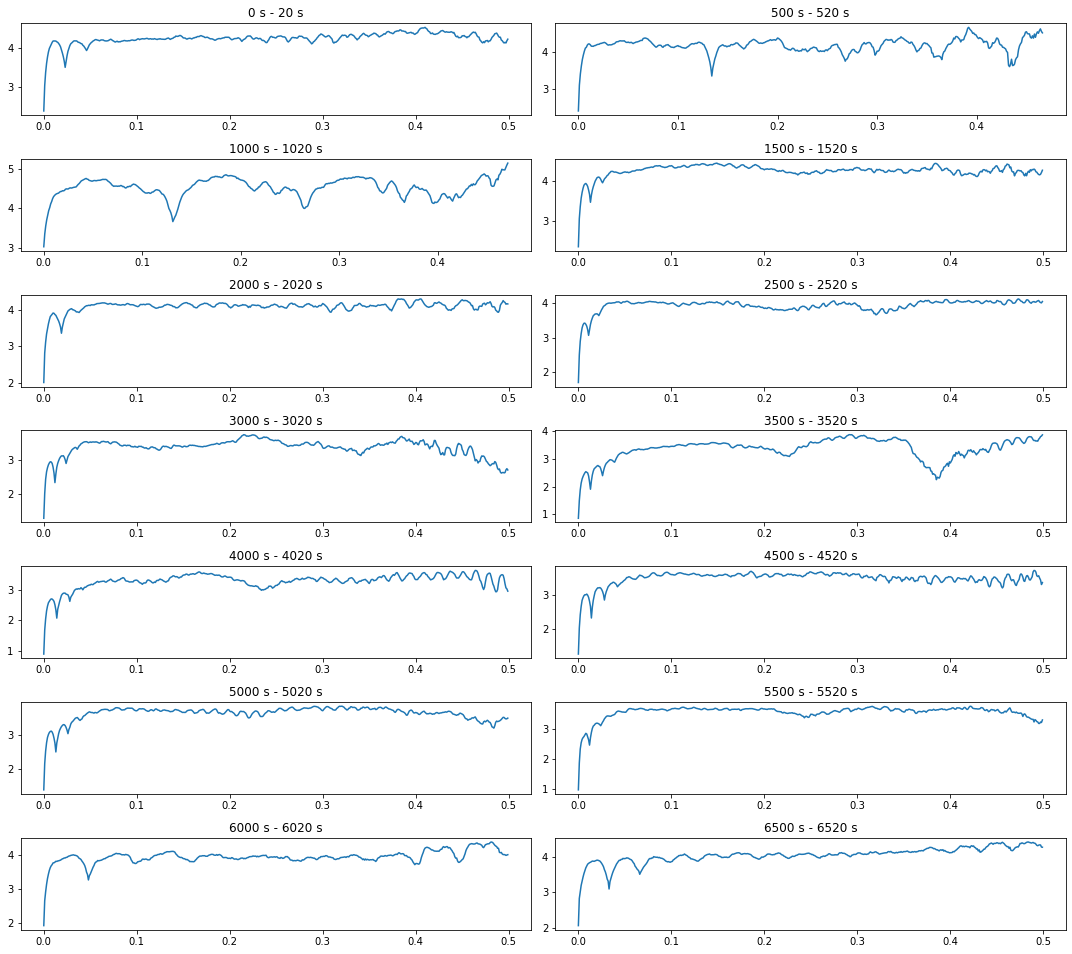

In [27]:
plt.figure(figsize=(15, 15))
for i, ret in enumerate(results_fr):
    plt.subplot(8, 2, i + 1)
    plt.plot((ret['t']*dt)[:len(ret['d'])], ret['d'])
    plt.title(f"{ret['start_time']} s - {ret['start_time'] + duration} s")
#     plt.xlabel(r'Time $t$')
#     plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.tight_layout()
plt.show()

### Filtering

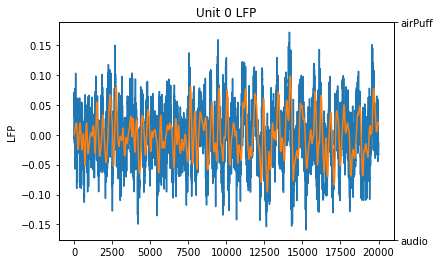

In [107]:
plt.plot(ret['signal'])
sos = signal.butter(3, 5, 'lp', fs=1000, output='sos')
filtered = signal.sosfilt(sos, ret['signal'])
plt.plot(filtered)
ax = plt.gca()
ax2 = ax.twinx()
ax2.fill_between(np.arange(len(ret['signal'])), 0, 1, where=ret['airPuff'], color='C2', alpha=0.6)
ax2.fill_between(np.arange(len(ret['signal'])), -1, 0, where=ret['audio'], color='C1', alpha=0.6)
ax2.set_yticks([-0.5, 0.5])
ax2.set_yticklabels(['audio', 'airPuff'])
ax.set_ylabel('LFP')
plt.title(f'Unit {unit_index} LFP')
plt.show()

In [108]:
# ==============
# INPUTS
# ==============

unit_index = 0
# trajectory_start_times = np.arange(0, 7001, 500) # s
duration = 20 # s

p = 1
r = 10
theiler_window = 500
maxt = 1000

#==========
start_step = int(1000/dt)
length = int(duration/dt)

# signal = f['lfp'][unit_index, start_step:start_step + length]
signal_in = filtered
ret = lyapunov_analysis(signal_in, p=p, r=r, theiler_window=theiler_window, maxt=maxt)
ret['signal'] = signal_in
ret['airPuff'] = airPuff_binary[start_step:start_step + length]
ret['audio'] = audio_binary[start_step:start_step + length]
ret['start_step'] = start_step

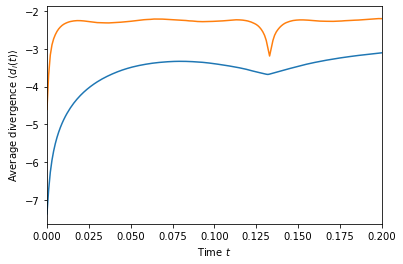

In [113]:
plt.plot(ret['t']*dt, ret['d'])
plt.plot(results[2]['t']*dt, results[2]['d'])
plt.xlim([0, 0.2])
plt.xlabel(r'Time $t$')
plt.ylabel(r'Average divergence $\langle d_i(t) \rangle$')
plt.show()